# Dataset Extraction

Author: Michael Dear, April 2024

This notebook is based on the following DEA notebooks:
* [Parallel Processing With Dask Beginner's Guide](https://knowledge.dea.ga.gov.au/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/)
* [Calculating Band Indices How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Calculating_band_indices/)
* [Generating Composite Images How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Generating_composites/)
* [Extract and Analyse Data for Multiple Polygons](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Analyse_multiple_polygons/)


In [19]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import geopandas as gpd

from datacube.drivers.netcdf import write_dataset_to_netcdf

import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

# For masking using a polygon
from shapely.geometry import mapping

# Turn off warnings to suppress dask all nan slice warnings
import warnings
warnings.filterwarnings('ignore')

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [3]:
dc = datacube.Datacube(app="Create_dataset")

## Step 1: Choose a study area
Use *one* of the methods below to set the bounding box for the study area.

### Method 1: Bounding box from centre point

In [102]:
# Grose Valley, NSW
cpoint = (-33.5976, 150.3651)
buffer = 0.0875
study_area_lat = (cpoint[0]+buffer, cpoint[0]-buffer)
study_area_lon = (cpoint[1]-buffer, cpoint[1]+buffer)

### Method 2: Bounding box from polygon

In [9]:
# Load the polygon
poly = gpd.read_file('../data/vector/lockleys-pilon.geojson')

In [10]:
poly.head()

,Name,geometry
0,lockleys-pilon-outline,"POLYGON ((150.39334 -33.62688, 150.39343 -33.6..."


In [11]:
# Set the CRS to EPSG:4326
poly = poly.to_crs(4326)

<Axes: >

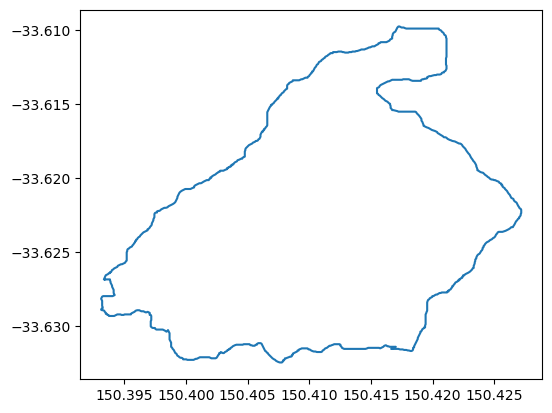

In [12]:
# Plot to check
poly.boundary.plot()

In [13]:
# Get the coordinates of the bounding box
bounds = poly.total_bounds
bounds

array([150.39312885, -33.63245231, 150.42718737, -33.60977046])

In [14]:
# Set the latitude and longitude
study_area_lat = (bounds[1], bounds[3])
study_area_lon = (bounds[0], bounds[2])

In [15]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Load data

In [30]:
dates = ['2019-11-01', '2019-11-06', '2023-10-21', '2023-10-31']

In [31]:
def get_data(date): 
    '''
    Function to load data for a given date
    '''
    ds = load_ard(dc=dc,
              products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
              measurements = ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir_1"],
              x=study_area_lon,
              y=study_area_lat,
              time=(date),
              output_crs='EPSG:3577', # 3308 NSW Lambert; 3577 Australian Albers; 4326 does not work - not sure why
              resolution=(-10, 10),
              group_by='solar_day',
              # dask_chunks={"time": 1, "x": 2048 , "y": 2048},
              cloud_mask='s2cloudless' # Uncomment if using Sentinel data
             )
    return ds

In [40]:
ds_raw = xr.concat([get_data(date) for date in dates], dim='time')

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps


In [41]:
ds_raw

<xarray.Dataset>
Dimensions:      (time: 4, y: 297, x: 348)
Coordinates:
  * time         (time) datetime64[ns] 2019-11-01T00:06:14.958968 ... 2023-10...
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 254.0 290.0 317.0 ... 442.0 408.0 377.0
    nbart_blue   (time, y, x) float32 247.0 262.0 277.0 ... 214.0 182.0 179.0
    nbart_green  (time, y, x) float32 331.0 382.0 445.0 ... 356.0 318.0 322.0
    nbart_nir_1  (time, y, x) float32 2.351e+03 2.707e+03 ... 2e+03 2.041e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [38]:
print('Dataset size = ', np.round(ds.nbytes/1024**3,3), 'Gb')

Dataset size =  0.006 Gb


### Create additional variables
Using the DEA's `calculate_indices` function is a quick way to add common indices as variables to the dataset.

*Note*: This function will automatically add the new variable to the given dataset.

#### Collections
* For Landsat (i.e. GA Landsat Collection 3), specify collection='ga_ls_3'.
* For Sentinel 2 (i.e. GA Sentinel 2 Collection 3), specify collection='ga_s2_3'

### Resample
Resampling along the time dimension can be useful for creating cloud-free composites and for reducing the size of the dataset. It is also possible to resample along the spatial dimensions, although it is probably easier to do this by changing the `resolution` in the `load_ard` function.

In [42]:
ds = ds_raw.resample(time='Y').mean()

In [44]:
# Add an NDVI variable
ds = calculate_indices(ds, index='NDVI', collection='ga_s2_3')

## Step 3: Plotting data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

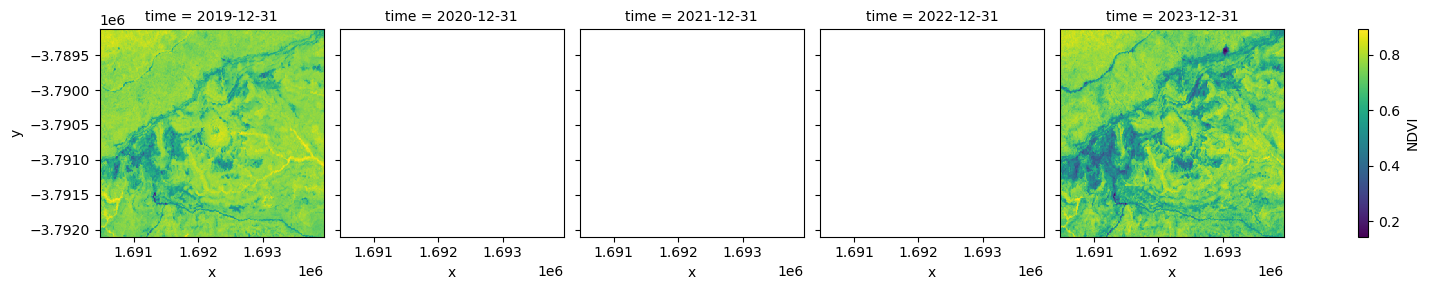

In [45]:
# Facetgrid plot of a single band
ds.NDVI.plot(col='time')

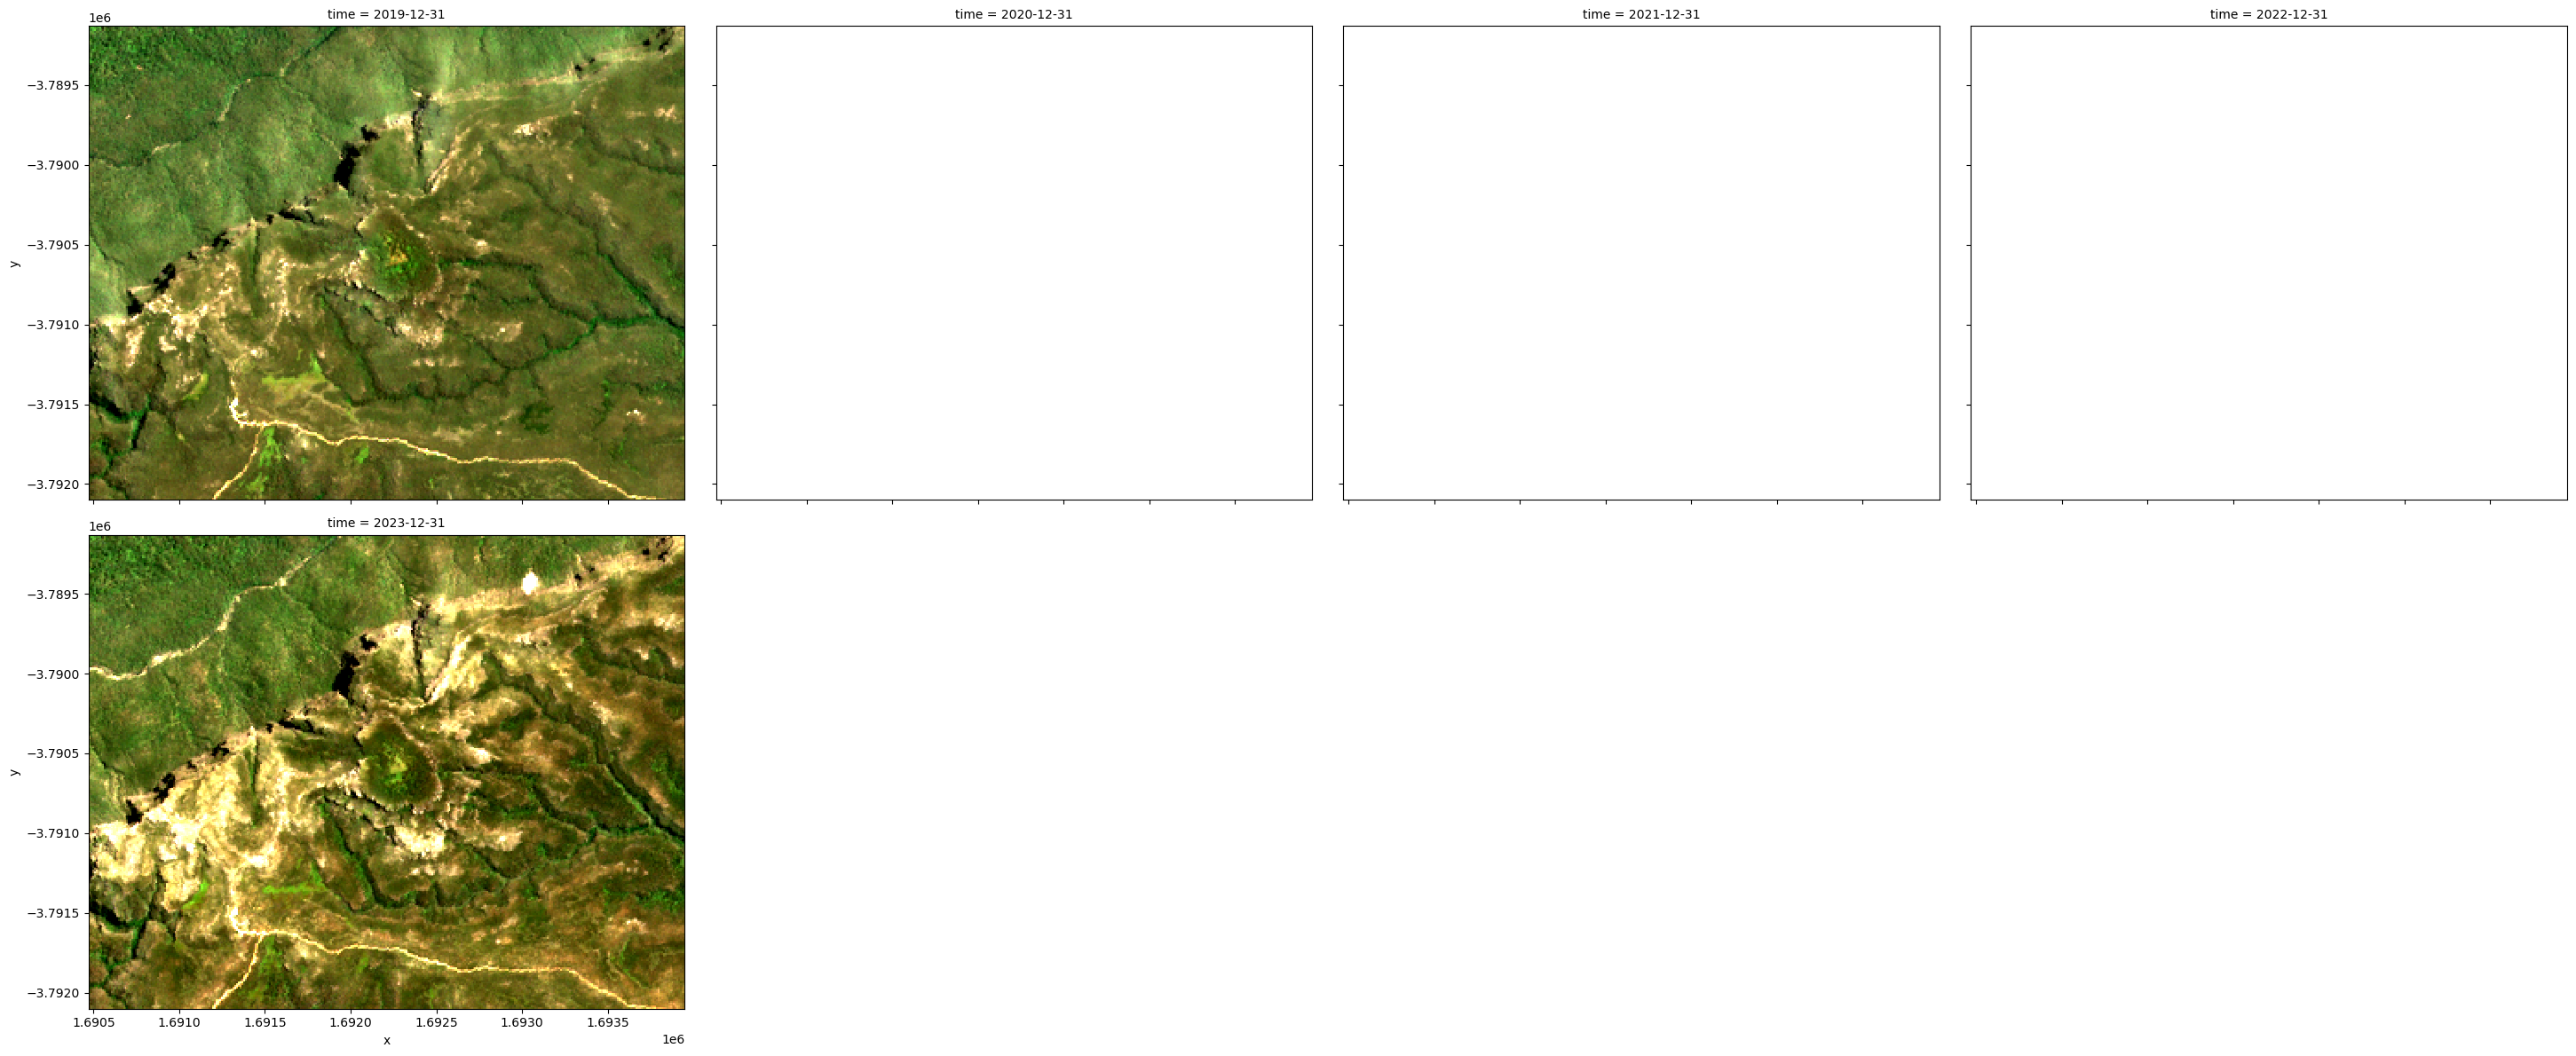

In [46]:
# RGB plot
rgb(ds, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    col='time')

## Step 4: Exporting data

In [49]:
# Remove CRS info because it prevents file saving
ds.time.attrs=[]

# Save as netCDF
ds.to_netcdf('../data/netcdf/lockleys-pilon_2019_2023.nc')